In [2]:
!pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [258]:
from sklearn.decomposition import PCA
# fetch dataset
wine = fetch_ucirepo(id=109)

# data (as pandas dataframes)
X = wine.data.features
y = wine.data.targets
# normalize
X_zscore = (X - X.mean()) / X.std()


# Assuming X is your data
pca = PCA(n_components=2)

X_pca = pca.fit_transform(X_zscore)

# Create a DataFrame for plotting
df_plot = pd.DataFrame({'PC1': X_pca[:, 0],
                        'PC2': X_pca[:, 1]})

df_plot["class"] = y.values

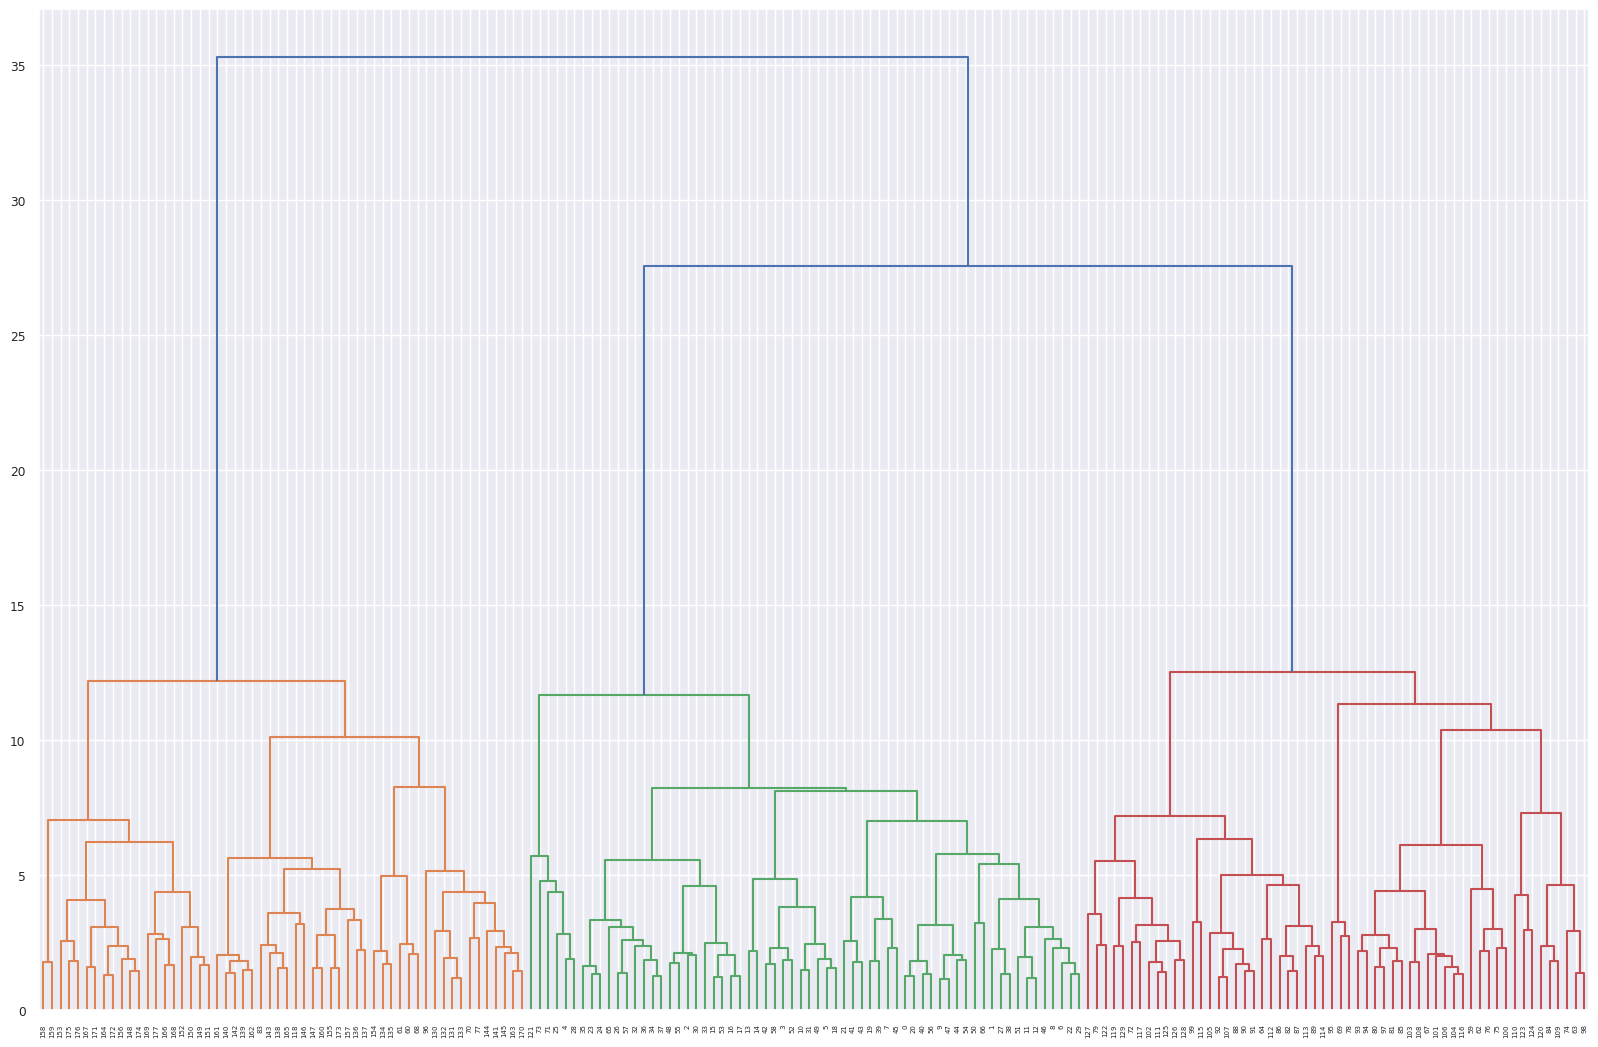

In [259]:

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

data = X_zscore.values
Z = linkage(data, 'ward')
fig = plt.figure(figsize=(20, 13))
dn = dendrogram(Z)
# 顯示樹狀圖
plt.show()

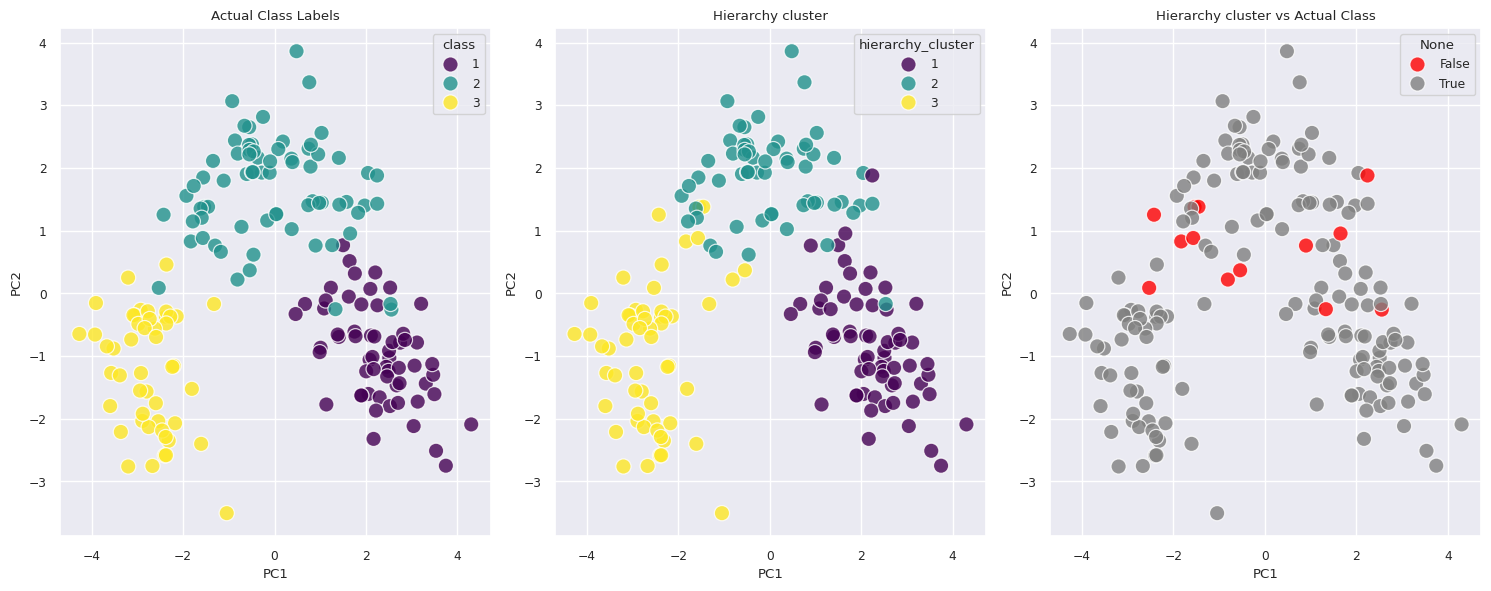

In [280]:

# 提取分群結果
num_clusters = 3  # 指定分群的數量
clusters = fcluster(Z, num_clusters, criterion='maxclust')


df_plot['hierarchy_cluster'] = clusters
map_cluster = {1: 3, 2: 1, 3: 2} # 調整顯示
df_plot['hierarchy_cluster'] = df_plot['hierarchy_cluster'].map(map_cluster)


# 查看層次分群結果
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
sns.scatterplot(x='PC1', y='PC2', hue="class", data=df_plot, s=120, alpha=0.8, palette='viridis')
plt.title("Actual Class Labels")

plt.subplot(1, 3, 2)
sns.scatterplot(x='PC1', y='PC2', hue="hierarchy_cluster", data=df_plot, s=120, alpha=0.8, palette='viridis')
plt.title("Hierarchy cluster")

plt.subplot(1, 3, 3)
sns.scatterplot(x='PC1', y='PC2', hue=df_plot['hierarchy_cluster'] == df_plot['class'], data=df_plot, s=120, alpha=0.8, palette={True:"gray", False:"red"})
plt.title("Hierarchy cluster vs Actual Class")

plt.tight_layout()



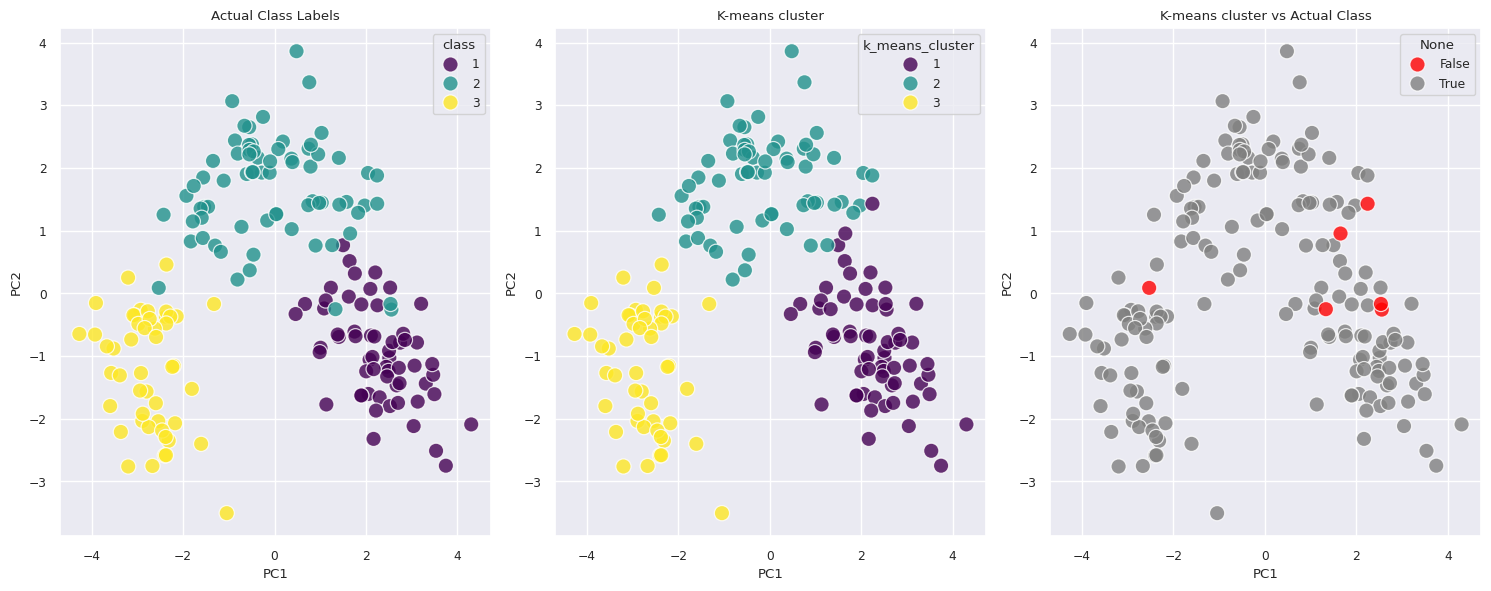

In [286]:
from sklearn.cluster import KMeans

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_plot['k_means_cluster'] = kmeans.fit_predict(X_pca)
df_plot['k_means_cluster'] = df_plot['k_means_cluster'].map({0: 3, 1: 1, 2: 2})

# 查看層次分群結果
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
sns.scatterplot(x='PC1', y='PC2', hue="class", data=df_plot, s=120, alpha=0.8, palette='viridis')
plt.title("Actual Class Labels")

plt.subplot(1, 3, 2)
sns.scatterplot(x='PC1', y='PC2', hue="k_means_cluster", data=df_plot, s=120, alpha=0.8, palette='viridis')
plt.title("K-means cluster")

plt.subplot(1, 3, 3)
sns.scatterplot(x='PC1', y='PC2', hue=df_plot['k_means_cluster'] == df_plot['class'], data=df_plot, s=120, alpha=0.8, palette={True:"gray", False:"red"})
plt.title("K-means cluster vs Actual Class")

plt.tight_layout()
plt.show()

對於每個資料點，計算它與同一集群中所有其他點的平均距離（a）<BR>
對於每個資料點，計算它與最接近的不同集群的所有點的平均距離（b）。<BR>
輪廓系數（S）等於（b - a）/ max(a, b)。

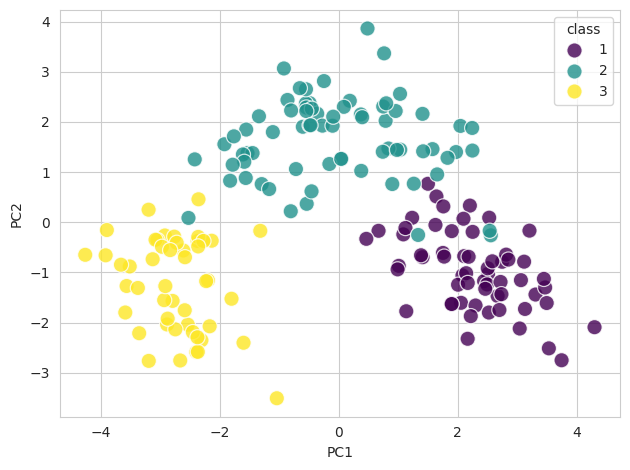

In [7]:
sns.scatterplot(x='PC1', y='PC2', hue="class", data=df_plot, s=120, alpha=0.8, palette='viridis')
plt.tight_layout()

此處顯示 均方殘差分數 和 inertia兩種評估方式

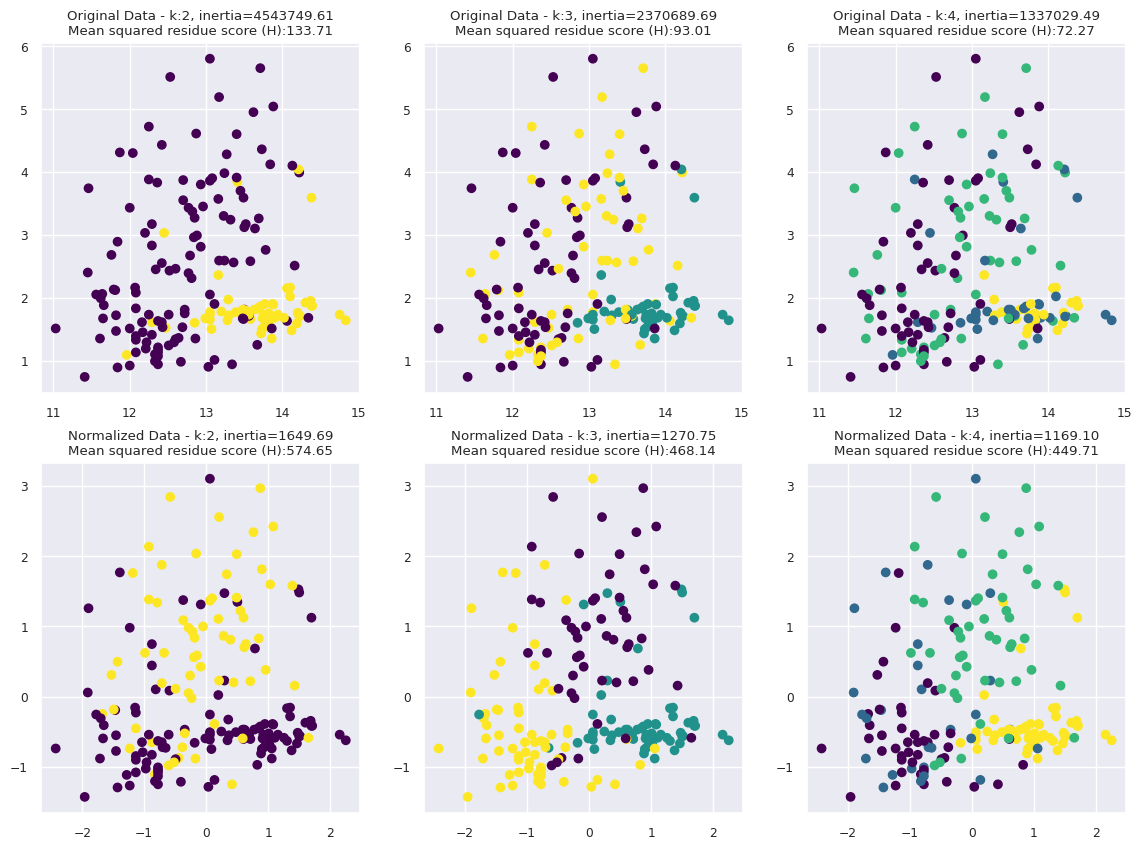

In [290]:
# normalized / raw data k-means

X_zscore = (X - X.mean()) / X.std()

fig, axs = plt.subplots(2, 3, figsize=(14, 10))
for i, k in enumerate([2, 3, 4]):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster = kmeans.fit_predict(X)
    # 均方殘差分數(H)
    H = np.min(kmeans.transform(X), axis=1).mean()

    axs[0, i].scatter(X.iloc[:, 0], X.iloc[:, 1], c=cluster, cmap='viridis')
    axs[0, i].set_title(f'Original Data - k:{k}, inertia={kmeans.inertia_:.2f}\nMean squared residue score (H):{H:.2f}')

    kmeans_normed = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_normed = kmeans_normed.fit_predict(X_zscore)

    H_zscore = np.min(kmeans.transform(X_zscore), axis=1).mean()
    axs[1, i].scatter(X_zscore.iloc[:, 0], X_zscore.iloc[:, 1], c=cluster_normed, cmap='viridis')
    axs[1, i].set_title(f'Normalized Data - k:{k}, inertia={kmeans_normed.inertia_:.2f}\nMean squared residue score (H):{H_zscore:.2f}')

plt.show()

展示選擇最佳模型的過程，我們自動選擇inertia下降最多，和silhouette_avg最大的參數作為最佳分群參數並視覺化。

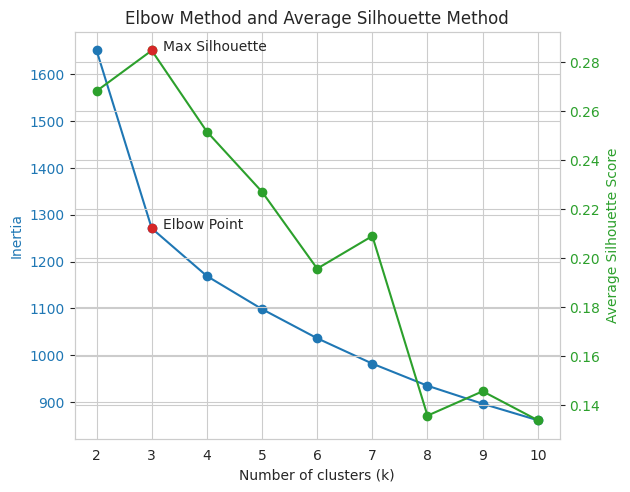

In [30]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

# Apply K-means clustering
inertia_values = []
silhouette_scores = []
k_list = list(range(2, 11))

for k in k_list:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_zscore)
    inertia_values.append(kmeans.inertia_)

    # 計算平均輪廓系數
    cluster_labels = kmeans.fit_predict(X_zscore)
    silhouette_avg = silhouette_score(X_zscore, cluster_labels)
    silhouette_scores.append(silhouette_avg)


fig, ax1 = plt.subplots()

# 繪製 Elbow 曲線
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia', color='tab:blue')
ax1.plot(k_list, inertia_values, marker='o', color='tab:blue', label='Inertia')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 繪製平均輪廓系數
ax2 = ax1.twinx()
ax2.set_ylabel('Average Silhouette Score', color='tab:green')
ax2.plot(k_list, silhouette_scores, marker='o', color='tab:green', label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor='tab:green')

# 找到最大的avg silhouette
max_silhouette_index = np.argmax(silhouette_scores)

# 找到下降最多的下一個點
derivative = np.diff(inertia_values, 2)
elbow_index = np.argmax(derivative) + 1

ax1.plot(k_list[elbow_index], inertia_values[elbow_index], marker='o', color='tab:red', label='Inertia')
ax2.plot(k_list[max_silhouette_index], silhouette_scores[max_silhouette_index], marker='o', color='tab:red', label='Silhouette Score')

ax1.text(k_list[elbow_index]+0.2, inertia_values[elbow_index], f'Elbow Point', ha='left')
ax2.text(k_list[max_silhouette_index]+0.2, silhouette_scores[max_silhouette_index], f'Max Silhouette', ha='left')

fig.tight_layout()
plt.title('Elbow Method and Average Silhouette Method')
plt.show()

In [33]:
!pip install scikit-fuzzy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894077 sha256=e9e0c2394c504f3a49b1e10e1b482f8e5561de08c48800c198ef8ca7b60c63ad
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


### FCM
Fuzzy可以做到軟分群效果，隸屬度可以讓一個資料點隸屬於多個群中
因此我採用將隸屬度轉換為色號來做視覺化，較原本寫法可以看出在邊界處的分群狀況。



### 參數:

centers: 最終的聚類中心。

u: 最終的隸屬度矩陣，其中每個元素u[i, j]表示數據點i對於聚類j的隸屬度。

u0: 初始的隸屬度矩陣。

d: 最終的距離矩陣，其中每個元素d[i, j]表示數據點i到聚類中心j的距離。

jm: 每次迭代的目標函數值。

p: 分區矩陣的指數值。

fpc: 模糊分區系數（Fuzzy Partition Coefficient），用於評估數據的聚類質量。該值越高，聚類質量越好。

In [195]:
import skfuzzy as fuzz

# 定義 FCM 模型參數
n_clusters = 3

# 使用 FCM 模型進行訓練
centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
                                X_zscore.T,
                                n_clusters,
                                2,
                                error=0.005,
                                maxiter=1000,
                                init=None)

# 取得每個資料點的最可能所屬的群集
predicted_labels = np.argmax(u, axis=0)
df_plot["fuzzy_labels"] = predicted_labels
df_plot["fuzzy_labels"] = df_plot["fuzzy_labels"].map({0: 1, 1: 2, 2: 3}) #用於調整顯示

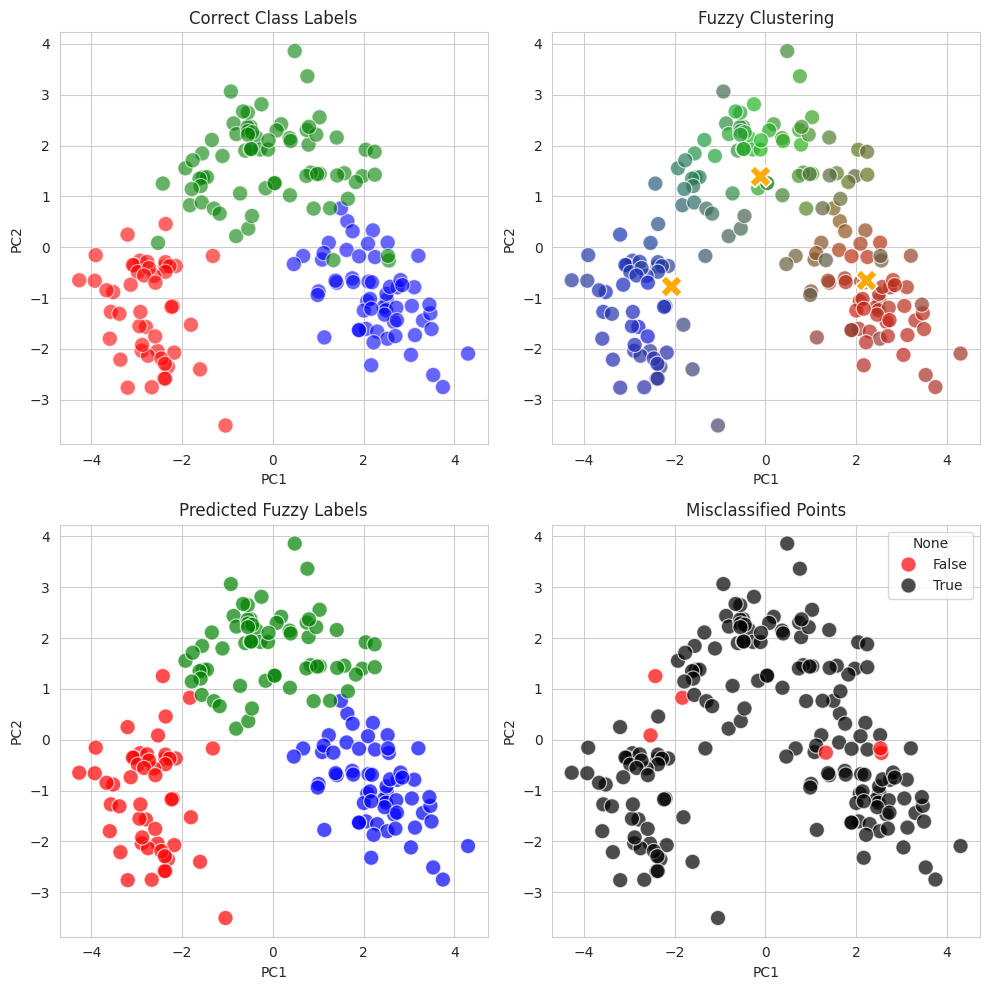

In [199]:
plt.figure(figsize=(10, 10))

# 正確答案轉換為RGB色號
plt.subplot(2, 2, 1)
class_colors = {3: "red", 2: "green", 1: "blue"}
df_plot["class_color"] = df_plot["class"].map(class_colors)
sns.scatterplot(x='PC1', y='PC2', data=df_plot, s=120, alpha=0.6, hue="class", palette=class_colors)
plt.legend().set_visible(False)
plt.title('Correct Class Labels')

# 使用PCA查看分群情形，並把屬於三個群集的機率轉為色號視覺化
plt.subplot(2, 2, 2)
hex_u = np.vectorize(hex)((u * 255).astype(np.int64)).T
hex_u_no_prefix = np.char.replace(hex_u, "0x", "").astype(str)
fuzzy_color = ["#" + h[0].zfill(2) + h[1].zfill(2) + h[2].zfill(2) for h in hex_u_no_prefix]
sns.scatterplot(x='PC1', y='PC2', data=df_plot, s=120, alpha=0.7, color=fuzzy_color)
plt.title('Fuzzy Clustering')

# 顯示分群中心
centers_pc = pca.fit_transform(centers)
sns.scatterplot(x=centers_pc[:, 0], y=centers_pc[:, 1], s=250, marker='X', zorder=1, c="#FFAA00")

# 畫出預測的最有可能分群
plt.subplot(2, 2, 3)
sns.scatterplot(x='PC1', y='PC2', data=df_plot, s=120, alpha=0.7, hue="fuzzy_labels", palette=class_colors)
plt.legend().set_visible(False)
plt.title('Predicted Fuzzy Labels')

# 顯示出與答案不同的圖表
plt.subplot(2, 2, 4)
sns.scatterplot(x='PC1', y='PC2', data=df_plot, s=120, alpha=0.7, hue=df_plot["fuzzy_labels"] == df_plot["class"], palette={True:"black", False:"red"})
plt.title('Misclassified Points')

plt.tight_layout()



In [200]:
!pip install minisom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.2-py3-none-any.whl size=10650 sha256=74faeeff4a122529272726b1d07d625cc2d9b9f89d1798a95acdda1e4bf3ec36
  Stored in directory: /root/.cache/pip/wheels/b4/f6/8a/9daf8831901c3e3805775633404248f10663d1c80b7e5a1314
Successfully built minisom


biclustering 在矩陣數據中尋找子矩陣，其中的行和列在某些方面具有相似性。這種方法在面對高維數據或具有嵌套結構的數據時特別有用。Biclustering 的目標是同時識別樣本（行）和特徵（列）的聚類結構，這種結構可能在不同的子集中出現。

[2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 0 2 1 1 1 2 1 0 2 0 1 1 1
 2 1 2 1 2 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[177 147 146 145 144 143 142 141 140 139 138 137 136 135 134 133 176 131
 130 118  61  68  70  83 148 149 132 151 175 174 173 172 150 170 169 168
 167 166 165 164 171 162 163 155 156 153 152 154 159 161 157 158 160 108
 107 106 105 104 103  92 102 101 100  97  96  94  93  91  99 112 110 129
 128 127 126 125 124 123 122 121 120 119 117 116 115 114 113 111 109  90
  88  87  89  25  63  64  65  67  71  72  73  75   4  60  84  77  79  80
  81  82  85  86  20  21  22  23  24   3  19  27  28  29  30  31  26  18
  15  16  14  13  12  11  10   9  32   8   1   7   6   2   5  17  33  42
  35  95  98  78  76  74  69  66  62  59  58  57  56  

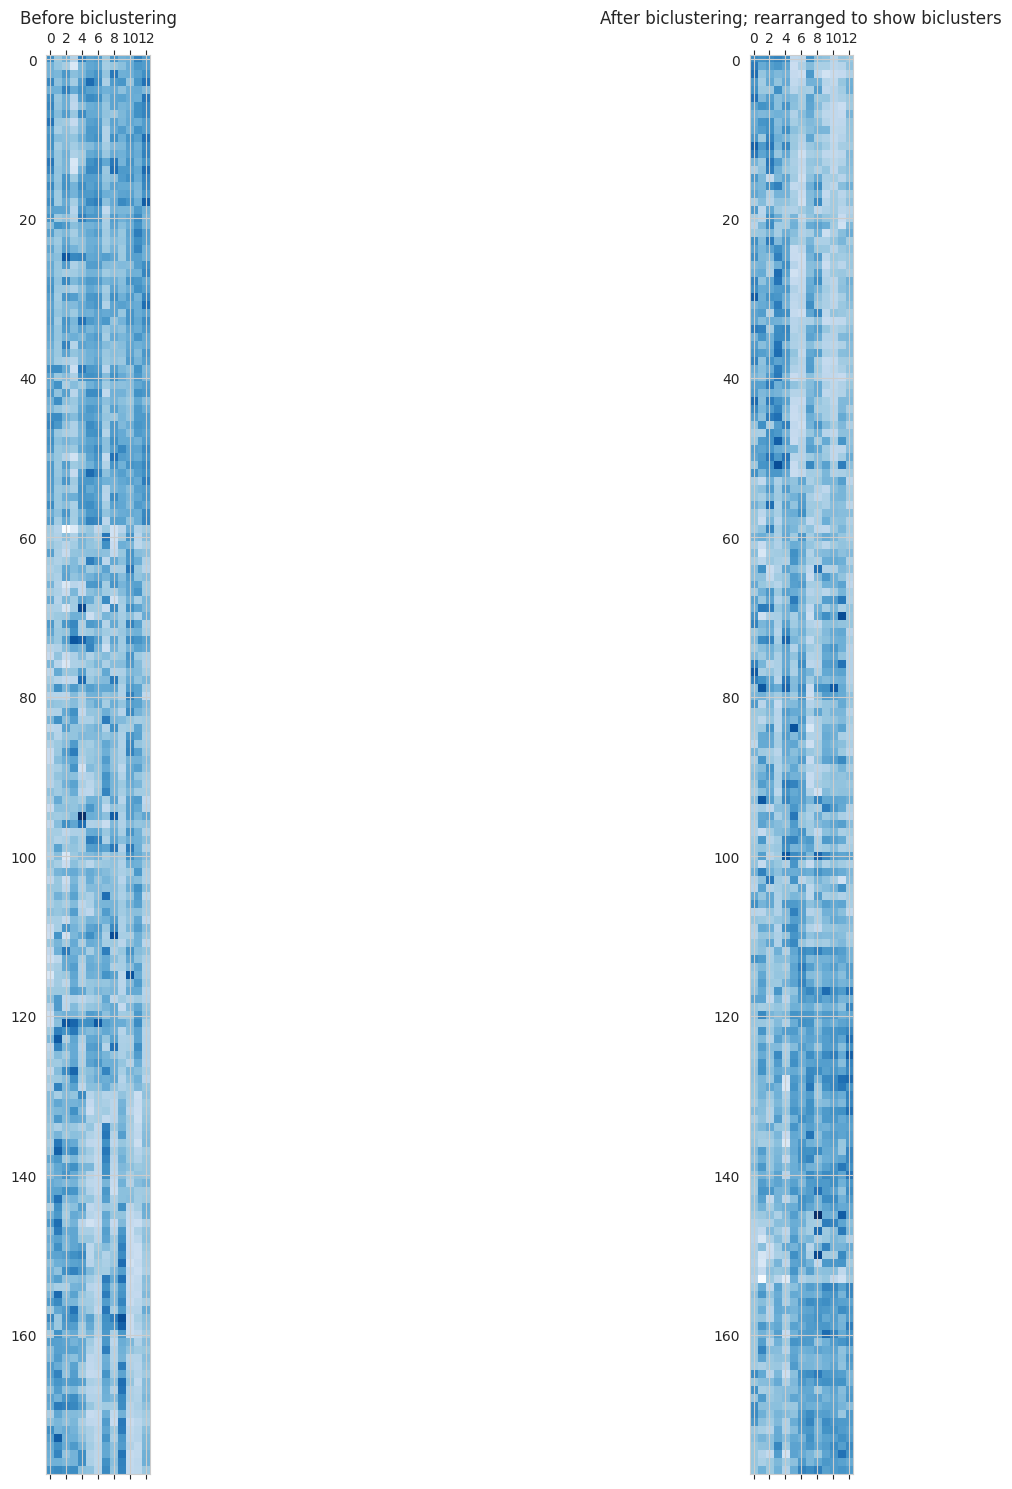

In [223]:
from sklearn.cluster import SpectralCoclustering

data = X_zscore.values  # 特徵資料

# 初始化 Spectral Co-clustering 模型
model = SpectralCoclustering(n_clusters=3, random_state=0)

# 訓練模型
model.fit(data)

# 取得行和列的聚類結果
row_labels = model.row_labels_
column_labels = model.column_labels_

print(row_labels)

# 取得行和列的重排索引
row_order = np.argsort(row_labels)
column_order = np.argsort(column_labels)

print(np.argsort(row_labels))

# 重新排序資料
data_reordered = data[row_order]
data_reordered = data_reordered[:, column_order]

fig, axes = plt.subplots(1, 2, figsize=(20, 15))

# 繪製排序前後
axes[0].matshow(data, cmap=plt.cm.Blues)
axes[0].set_title("Before biclustering")

axes[1].matshow(data_reordered, cmap=plt.cm.Blues)
axes[1].set_title("After biclustering; rearranged to show biclusters")

plt.tight_layout()
plt.show()